In [3]:
import nb_setup 
import importlib
importlib.reload(nb_setup)
nb_setup.init()

Added project root to sys.path: /Users/falconlin/Development/backtesting-playground/trading
Changed current working directory to: /Users/falconlin/Development/backtesting-playground/trading
Initialized project with base directory: /Users/falconlin/Development/backtesting-playground/trading


In [4]:
import pandas as pd
from settings import DATA_DIR

df = pd.read_csv(DATA_DIR / "all_ranked.csv", index_col=[0])
df.head()

,start_time,average_rank,rank_rolling_accumulated_pct_change,rank_rolling_variance_pct_change,open,close
symbol,,,,,,
BTC,2024-02-10 00:00:00,NaN,NaN,NaN,47166.0,47244.0
BTC,2024-02-10 00:15:00,46.0,46.0,NaN,47244.0,47204.0
BTC,2024-02-10 00:30:00,23.0,42.0,4.0,47204.0,47147.0
BTC,2024-02-10 00:45:00,18.0,34.0,2.0,47146.0,47116.0
BTC,2024-02-10 01:00:00,13.0,24.0,2.0,47122.0,47110.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 164217 entries, BTC to LDO
Data columns (total 6 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   start_time                           164217 non-null  object 
 1   average_rank                         164160 non-null  float64
 2   rank_rolling_accumulated_pct_change  164160 non-null  float64
 3   rank_rolling_variance_pct_change     164103 non-null  float64
 4   open                                 164217 non-null  float64
 5   close                                164217 non-null  float64
dtypes: float64(5), object(1)
memory usage: 8.8+ MB


In [8]:
import numpy as np
import pandas as pd


def _initialize(df_final):
    # Initial principal amount
    principal = 1_000_000

    # Assuming df_final is your prepared DataFrame
    df_final["start_time"] = pd.to_datetime(df_final["start_time"])
    df_final = df_final.sort_values(by=["start_time", "average_rank"])

    # Find unique timestamps
    timestamps = df_final["start_time"].unique()

    return df_final, principal, timestamps


def _get_intervals(
    df_final,
    current_time,
    i,
    trading_interval,
    timestamps,
    verbose,
):
    """
    Inputs:
    df_final: DataFrame
    current_time: Timestamp
    i: int  # Index of the current loop
    trading_interval: DataFrame
    timestamps: list of start_times
    verbose: bool
    """
    if i + trading_interval < len(timestamps):
        close_time = timestamps[i + trading_interval]
    else:
        close_time = timestamps[-1]

    if verbose:
        print("Current time:", current_time)
        print("Close time:", close_time)

    # Filter the DataFrame for the current timestamp
    last_interval = df_final[
        df_final["start_time"] == current_time - pd.Timedelta(minutes=15)
    ]

    current_interval = df_final[(df_final["start_time"] == current_time)]

    if verbose:
        print(
            # current_interval.loc[:, ["start_time", "open", "close"]].head(),
        )

    return last_interval, current_interval, close_time


def calculate_returns(
    df_final,
    trading_interval=1,
    verbose=False,
    loop=None,
    slippage_and_cost=0.003,
    transaction_cost=0.00025,
):
    # Initialize
    df_final, principal, timestamps = _initialize(df_final)
    results = []

    # Adjust loop to step through timestamps according to trading_interval
    current = -1
    for i in range(0, len(timestamps) - trading_interval, trading_interval):
        current += 1
        if loop is not None and current == loop:
            break

        current_time = timestamps[i]
        print("---------------------------------------------")
        print("Current time:", current_time, i)
        print("---------------------------------------------")

        # Ensure we do not go out of bounds for the last interval
        last_interval, current_interval, close_time = _get_intervals(
            df_final,
            current_time,
            i,
            trading_interval,
            timestamps,
            verbose,
        )
        if current_interval.empty or last_interval.empty:
            print("Empty interval, skipping")
            continue

        # Calculate investment per coin
        investment_per_coin = principal / 20  # Divided among top 10 and bottom 10

        # For the top 10 and bottom 10, we need the open price at current_time and close price at close_time
        top_10 = last_interval.head(10).copy()
        bottom_10 = last_interval.tail(10).copy()

        if (
            np.isnan(top_10["average_rank"]).all()
            or np.isnan(bottom_10["average_rank"]).all()
            or i == 2
        ):
            interval_return = 0
            principal += interval_return
        else:
            # top 10 ranked coins prices
            top_10_open_prices = current_interval.loc[top_10.index, "open"].values
            bottom_10_open_prices = current_interval.loc[bottom_10.index, "open"].values

            # Get closing prices at close_time
            future_interval = df_final[
                df_final["start_time"] == close_time - pd.Timedelta(minutes=15)
            ]
            if future_interval.empty:
                print("Empty future interval, skipping")
                continue
            top_10_close_prices = future_interval.loc[top_10.index, "close"].values
            bottom_10_close_prices = future_interval.loc[
                bottom_10.index, "close"
            ].values

            if verbose:
                print("top_10.shape", top_10.shape)
                print("bottom_10.shape", bottom_10.shape)
                print("last_interval.shape", last_interval.shape)
                print("current_interval.shape", current_interval.shape)
                print("future_interval.shape", future_interval.shape)
                print("top_10_open_prices", len(top_10_open_prices))
                print("top_10_close_prices", len(top_10_close_prices))
                print("bottom_10_open_prices", len(bottom_10_open_prices))
                print("bottom_10_close_prices", len(bottom_10_close_prices))
                # print(bottom_10.loc[:, ["start_time", "open", "close"]].head())
                # print(current_interval.loc[:, ["start_time", "open", "close"]].head())
                # print(future_interval.loc[:, ["start_time", "open", "close"]].head())

            # Long the top 10

            long_asset = (
                (
                    -top_10_open_prices
                    * (1 + slippage_and_cost)
                    # - top_10_open_prices * (1 + slippage_and_cost) * (transaction_cost)
                )
                * (investment_per_coin)
                / (top_10_open_prices * (1 + slippage_and_cost))
            )

            sell_longed_asset = (
                (
                    +top_10_close_prices
                    * (1 - slippage_and_cost)
                    # - top_10_close_prices * (1 - slippage_and_cost) * (transaction_cost)
                )
                * (investment_per_coin)
                / (top_10_open_prices * (1 + slippage_and_cost))
            )
            long_returns = long_asset + sell_longed_asset

            # Short the bottom 10
            short_asset = (
                (
                    bottom_10_open_prices
                    * (1 - slippage_and_cost)
                    # - bottom_10_open_prices
                    # * (1 - slippage_and_cost)
                    # * (transaction_cost)
                )* (investment_per_coin)
                / (bottom_10_open_prices * (1 - slippage_and_cost))
            ) 

            buy_shorted_asset = (
                (
                    -bottom_10_close_prices
                    * (1 + slippage_and_cost)
                    # - bottom_10_close_prices
                    # * (1 + slippage_and_cost)
                    # * (transaction_cost)
                )* (investment_per_coin)
                / (bottom_10_open_prices * (1 - slippage_and_cost))
            ) 
            short_returns = short_asset + buy_shorted_asset

            # Calculate returns
            interval_return = long_returns.sum() + short_returns.sum()
            principal += interval_return

            if verbose:
                print("=========Verbose Section===========")
                print(
                    "top_10_open_prices", top_10_open_prices * (1 + slippage_and_cost)
                )
                print(
                    "top_10_close_prices", top_10_close_prices * (1 - slippage_and_cost)
                )
                print(
                    "bottom_10_open_prices",
                    bottom_10_open_prices * (1 - slippage_and_cost),
                )
                print(
                    "bottom_10_close_prices",
                    bottom_10_close_prices * (1 + slippage_and_cost),
                )
                print("long_asset", long_asset)
                print("sell_longed_asset", sell_longed_asset)
                print("long_returns", long_returns)
                print("short_asset", short_asset)
                print("buy_shorted_asset", buy_shorted_asset)
                print("short_returns", short_returns)

        results.append(
            {
                "timestamp": current_time,
                "return": interval_return,
                "principal": principal,
            }
        )

        print("---------------------------------------------")
        print(
            f"For interval {i//trading_interval} starting at {current_time}: Long {top_10.index.values}, Short {bottom_10.index.values}"
        )
        print(
            f"For interval {i//trading_interval} starting at {current_time}: Long {top_10['average_rank'].values}, Short {bottom_10['average_rank'].values}"
        )
        print(
            f"In this interval, the return is {interval_return}, new principal is {principal}"
        )

    # Summarize results
    results_df = pd.DataFrame(results)
    if "return" not in results_df.columns:
        print("No returns calculated")
        return results_df
    total_performance = results_df["return"].sum()
    print("Total simulated return over the period:", total_performance)
    return results_df


# Example usage, assuming df is your DataFrame
results_df = calculate_returns(
    df,
    trading_interval=92,
    loop=None,
    verbose=False,
    slippage_and_cost=0.003,
    transaction_cost=0,
)  # Adjust trading_interval as needed

---------------------------------------------
Current time: 2024-02-10 00:00:00 0
---------------------------------------------
Empty interval, skipping
---------------------------------------------
Current time: 2024-02-10 23:00:00 92
---------------------------------------------
---------------------------------------------
For interval 1 starting at 2024-02-10 23:00:00: Long ['BTC' 'MKR' 'ETH' 'LTC' 'DOGE' 'BNB' 'kSHIB' 'XRP' 'SOL' 'ADA'], Short ['ORDI' 'BLUR' 'JUP' 'OP' 'RNDR' 'RUNE' 'SUI' 'SEI' 'ALT' 'AI']
For interval 1 starting at 2024-02-10 23:00:00: Long [10.5 11.  15.  15.5 16.  16.5 16.5 17.5 18.  19. ], Short [40.5 41.  41.5 41.5 42.  42.  46.  50.  50.  50.5]
In this interval, the return is -16571.026073202236, new principal is 983428.9739267977
---------------------------------------------
Current time: 2024-02-11 22:00:00 184
---------------------------------------------
---------------------------------------------
For interval 2 starting at 2024-02-11 22:00:00: Long ['

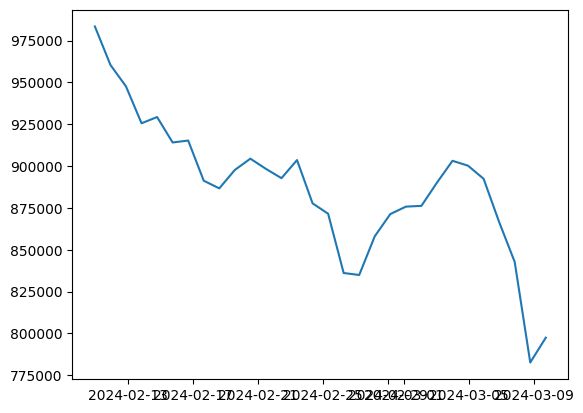

In [9]:
import matplotlib.pyplot as plt 
results_df.head()

# plt.figure(figsize=(14, 7))
plt.plot(results_df["timestamp"], results_df["principal"])

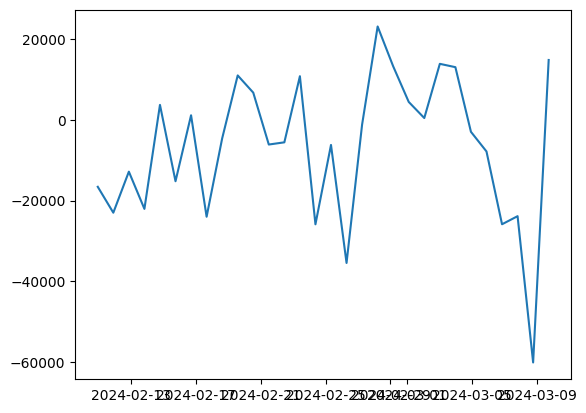

In [10]:
plt.plot(results_df["timestamp"], results_df["return"])


In [11]:
results_df["return"].describe()

count       30.000000
mean     -6751.015908
std      18074.665029
min     -60075.976485
25%     -20673.313683
50%      -5076.188140
75%       6173.643844
max      23134.053248
Name: return, dtype: float64